In [1]:
import numpy as np
import matplotlib as mpl
import collections
import copy
from qbstyles import mpl_style
import gym
from gym import spaces
import or_gym
from or_gym.utils.env_config import *
from or_gym.algos.rl_utils import create_env
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
mpl_style(dark=False)

In [2]:
class InvManagementMaster(gym.Env):
    
    def __init__(self, demand=None, *args, **kwargs):
        
        self.step_limit = 30
        self.initial_inventory = np.array([100, 100, 200])
        self.unit_price = np.array([2, 1.5, 1, 0.75])                                       # p
        self.unit_cost = np.array([1.5, 1.0, 0.75, 0.5])          # r
        self.backlog_cost = np.array([0.1, 0.075, 0.05, 0.025])   # k
        self.holding_cost = np.array([0.15, 0.1, 0.05])           # h
        self.supply_capacity = np.array([100, 90, 80])            # c
        self.lead_times = np.array([3, 5, 10])                    # L
        self.backlog = True
        self.dist = 1
        self.dist_param = {'mu': 20}
        self.alpha = 0.97
        self.seed_int = 0
        self.user_dist = np.zeros(self.step_limit)
        self.num_stages = len(self.initial_inventory) + 1
        
        distributions = {1: stats.poisson,
                         2: stats.binom,
                         3: stats.randint,
                         4: stats.geom,
                         5: self.user_dist}
        self.demand_dist = distributions[self.dist]
        if self.dist < 5:
            self.seed(self.seed_int)
        if demand is not None:
            self.demand_dist = demand
        
        self.action_space = spaces.Box(
            low=np.zeros(self.num_stages-1), high=self.supply_capacity, dtype=np.int16)
        self.observation_space = spaces.Box(
            low=-np.ones(self.num_stages-1)*self.supply_capacity.max()*self.step_limit*10,
            high=self.supply_capacity*self.step_limit)
        
        self.reset()
        
    def seed(self, seed=None):
        if seed != None:
            np.random.seed(seed=int(seed))

    def reset(self):
        self.current_step = 0
        self.inventory_levels = np.zeros((self.step_limit, 
            self.num_stages-1), dtype=np.int16)
        self.inventory_in_transit = self.inventory_levels.copy()
        self.backlog_orders = np.zeros((self.step_limit,
            self.num_stages), dtype=np.int16)
        self.retail_demand = np.zeros(self.step_limit)
        self.profits = self.retail_demand.copy()
        self.inventory_levels[0] = self.initial_inventory.copy()
        self.recievables = self.inventory_in_transit.copy()
        self.order_history = np.zeros((self.step_limit, self.num_stages-1))
        self.state = self.initial_inventory.copy()
        return self.state

    def step(self, action):
        action = np.maximum(action, 0).astype(int)
        t = self.current_step
        self.order_history[t] = action.copy()
        current_inventory = self.inventory_levels[t].copy()
        current_backlog = self.backlog_orders[t].copy()
        shipments = np.zeros(self.num_stages)
        # Receive inventory in transit
        for i in range(self.num_stages - 1):
            if t - self.lead_times[i] >= 0:
                current_inventory[i] += self.inventory_in_transit[t - self.lead_times[i], i]
                self.recievables[t, i] += self.inventory_in_transit[t - self.lead_times[i], i]

        # Sell retail demand
        if self.dist < 5:
            retail_demand = self.demand_dist.rvs(**self.dist_param)
        else:
            retail_demand = self.demand_dist[t]
        
        total_demand = current_backlog.copy()
        total_demand[0] += retail_demand
        total_demand[1:] += action
        shipments[-1] = total_demand[-1] # Add capacity limit at this stage
        for i in range(self.num_stages - 1):
            if current_inventory[i] >= total_demand[i]:
                shipments[i] += total_demand[i]
                current_inventory[i] -= total_demand[i]
                current_backlog[i] = 0
            else:
                current_backlog[i] = total_demand[i] - current_inventory[i]
                shipments[i] += current_inventory[i]
                # Update shipments
                current_inventory[i] = 0
        # Add case for when we use lost sales vs backlog penalty
        reward = np.sum(shipments*self.unit_price) - \
            (np.sum(self.unit_cost*shipments + self.backlog_cost*current_backlog) \
             + np.sum(self.holding_cost*current_inventory))

        
        self.inventory_in_transit[t] = shipments[1:].copy()
        
        self.current_step += 1
        
        done = True if self.current_step >= self.step_limit else False
        
        self.state = current_inventory.copy()
        if not done:
            self.inventory_levels[self.current_step] = current_inventory.copy()
            self.backlog_orders[self.current_step] = current_backlog.copy()
        
        # Log values
        self.retail_demand[t] += retail_demand
        self.profits[t] += reward        
        
        return self.state, reward, done, {
            'retail_demand': retail_demand,
            'shipments': shipments,
            'inventory_in_transit': self.inventory_in_transit.sum(axis=0),
            'backlog': self.backlog_orders.sum(axis=0)}

In [3]:
env = InvManagementMaster()
ep_rewards = []
for i in range(1000):
    s = env.reset()
    R = 0
    done = False
    while done == False:
        valid_obs = env.observation_space.contains(s)
        action = env.action_space.sample()
        valid_action = env.action_space.contains(action)
        s, r, done, _ = env.step(action)
        R += r
        if not valid_obs:
            print("Invalid observation:\t{}".format(s))
        if not valid_action:
            print("Invalid action:\t{}".format(action))
        if done:
            ep_rewards.append(R)

In [4]:
np.mean(ep_rewards), np.min(ep_rewards), np.max(ep_rewards)

(-415.83189999999996, -1193.375, 571.7250000000001)

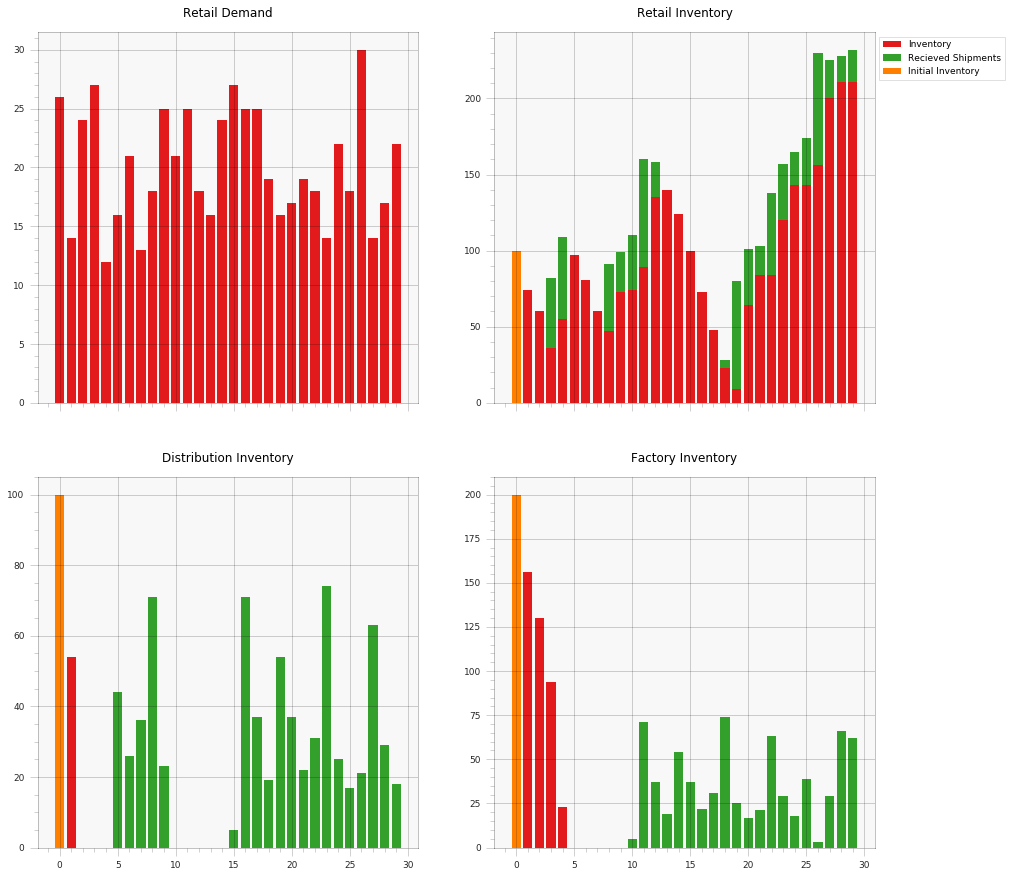

In [5]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax[0, 0].bar(np.arange(env.step_limit), env.retail_demand)
ax[0, 0].set_title('Retail Demand')

ax[0, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 0], label='Inventory')
ax[0, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 0], 
             bottom=env.inventory_levels[1:, 0], label='Recieved Shipments')
ax[0, 1].bar(0, env.initial_inventory[0], label='Initial Inventory')
ax[0, 1].set_title('Retail Inventory')
ax[0, 1].legend(bbox_to_anchor=[1, 1])

ax[1, 0].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 1], label='Inventory')
ax[1, 0].bar(np.arange(1, env.step_limit), env.recievables[1:, 1], 
             bottom=env.inventory_levels[1:, 1], label='Recieved Shipments')
ax[1, 0].bar(0, env.initial_inventory[1], label='Initial Inventory')
ax[1, 0].set_title('Distribution Inventory')

ax[1, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 2], label='Inventory')
ax[1, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 2], 
             bottom=env.inventory_levels[1:, 2], label='Recieved Shipments')
ax[1, 1].bar(0, env.initial_inventory[2], label='Initial Inventory')
ax[1, 1].set_title('Factory Inventory')

plt.show()

# Test with Ray

In [6]:
import ray
from ray.rllib import agents
from copy import deepcopy
import time

In [7]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=create_env('InvManagement-v0'))
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [8]:
ray.init(ignore_reinit_error=True)
trainer, results = train_agent()

2020-05-14 16:38:53,170	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-14 16:38:53,172	INFO resource_spec.py:216 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-14 16:38:53,720	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-14 16:38:53,753	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-05-14 16:39:11,317	INFO trainable.py:102 -- _setup took 17.566 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-05-14 16:39:11,319	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': -2532.4238, 'policy_entropy': 61.4198, 'var_gnorm': 22.89989, 'vf_loss': 11583.659, 'model': {}, 'grad_gnorm': 40.000004, 'vf_explained_var': 0.0014209747}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 11308.355, 'policy_entropy': 125.76327, 'var_gnorm': 23.24792, 'vf_loss': 48570.707, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.15370637}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -6365.713, 'policy_entropy': 142.90929, 'var_gnorm': 23.725739, 'vf_loss': 15437.881, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.028253198}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -1973.1423, 'policy_entropy': 130.25423, 'var_gnorm': 25.048357, 'vf_loss': 4664.285, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.5026797}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 6079.6064, 'policy_entropy': 108.84271, 'var_gnorm': 26.74982, 'vf_loss': 25671.605, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.37470

{'cur_lr': 9.999999747378752e-05, 'policy_loss': -48195.29, 'policy_entropy': 609.17664, 'var_gnorm': 38.67057, 'vf_loss': 38165.703, 'model': {}, 'grad_gnorm': 39.999996, 'vf_explained_var': -0.046762347}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -74302.21, 'policy_entropy': 594.2096, 'var_gnorm': 38.87959, 'vf_loss': 84174.98, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.30596334}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -135758.86, 'policy_entropy': 629.53235, 'var_gnorm': 39.079376, 'vf_loss': 288322.0, 'model': {}, 'grad_gnorm': 39.999996, 'vf_explained_var': -0.013166189}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 95150.266, 'policy_entropy': 635.62787, 'var_gnorm': 39.263084, 'vf_loss': 130912.7, 'model': {}, 'grad_gnorm': 39.99999, 'vf_explained_var': 0.150922}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -53723.773, 'policy_entropy': 638.98584, 'var_gnorm': 39.412823, 'vf_loss': 40932.254, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 

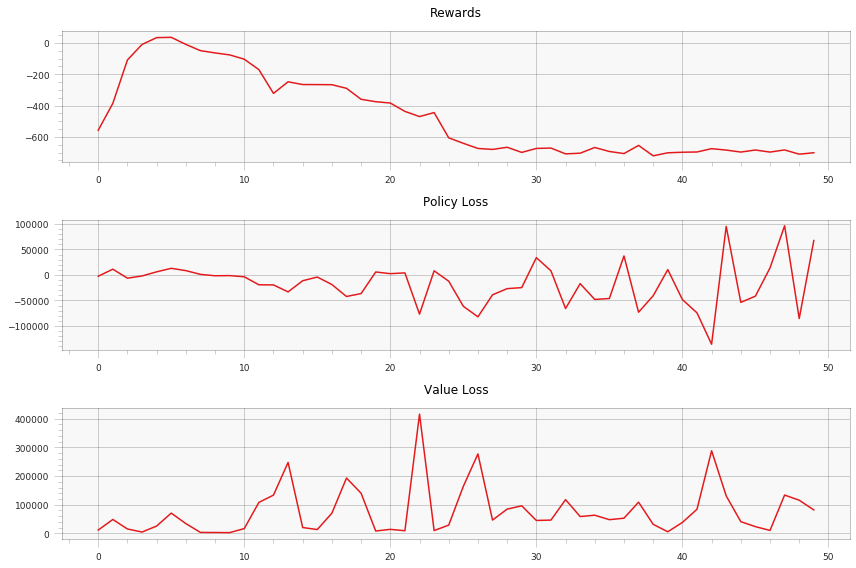

In [9]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

# Compare to Hector's Environment

In [10]:
trainer.config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 10,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 200,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': 'InvManagementBacklogEnv',
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0001,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': No

2020-05-14 16:54:14,491	ERROR worker.py:956 -- print_logs: Connection closed by server.
2020-05-14 16:54:14,492	ERROR worker.py:1056 -- listen_error_messages_raylet: Connection closed by server.
2020-05-14 16:54:14,493	ERROR import_thread.py:97 -- ImportThread: Connection closed by server.


(pid=raylet) *** Aborted at 1589493254 (unix time) try "date -d @1589493254" if you are using GNU date ***
(pid=raylet) PC: @                0x0 (unknown)
(pid=raylet) *** SIGTERM (@0x3e800005e5a) received by PID 23399 (TID 0x7f0564787740) from PID 24154; stack trace: ***
(pid=raylet)     @     0x7f0563cfc390 (unknown)
(pid=raylet)     @     0x7f056360a9f3 epoll_wait
(pid=raylet)     @           0x418e1c boost::asio::detail::epoll_reactor::run()
(pid=raylet)     @           0x4194b9 boost::asio::detail::scheduler::run()
(pid=raylet)     @           0x409c5f main
(pid=raylet)     @     0x7f0563523830 __libc_start_main
(pid=raylet)     @           0x40ed81 (unknown)


In [3]:
demand = np.ones(30)*2
env1 = InvManagementMaster(demand=demand)
env1.dist = 5
env2 = or_gym.make('InvManagement-v0', env_config={'demand_dist': demand, 'dist': 5, 'user_D': demand})
# env2.demand_dist = demand.copy()
# env2.dist = 5
# env2.reset()
# env2.user_D = demand.copy()

In [4]:
# env1 = InvManagementMaster()
# env2 = or_gym.make('InvManagement-v0')

action = [1, 1, 1]

ep_rewards1, ep_rewards2 = [], []
for n in range(1):
    s1, s2 = [], []
    r1, r2 = [], []
    env1.reset()
    env2.reset()
    for i in range(env1.step_limit):
#         print("Env 1")
        s_1, r_1, done, _ = env1.step(action)
#         print("Env 2")
        s_2, r_2, done, _ = env2.step(action)
        s1.append(s_1)
        r1.append(r_1)
        s2.append(s_2)
        r2.append(r_2)
        
    ep_rewards1.append(sum(r1))
    ep_rewards2.append(sum(r2))

In [5]:
np.mean(ep_rewards1)

-880.4499999999999

In [6]:
np.mean(ep_rewards2)

-563.805223508766

ValueError: x and y must be the same size

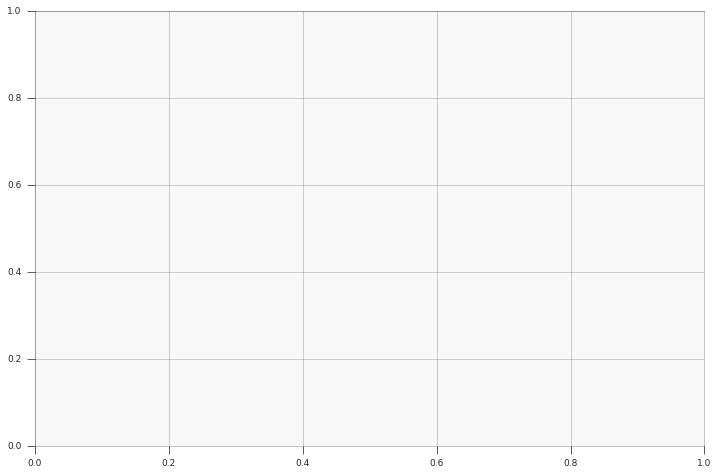

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(1000), np.array(ep_rewards1), label='Env 1')
plt.scatter(np.arange(1000), ep_rewards2, label='Env 2')
plt.show()

In [8]:
s1

[array([ 98,  99, 199], dtype=int16),
 array([ 96,  98, 198], dtype=int16),
 array([ 94,  97, 197], dtype=int16),
 array([ 93,  96, 196], dtype=int16),
 array([ 92,  95, 195], dtype=int16),
 array([ 91,  95, 194], dtype=int16),
 array([ 90,  95, 193], dtype=int16),
 array([ 89,  95, 192], dtype=int16),
 array([ 88,  95, 191], dtype=int16),
 array([ 87,  95, 190], dtype=int16),
 array([ 86,  95, 190], dtype=int16),
 array([ 85,  95, 190], dtype=int16),
 array([ 84,  95, 190], dtype=int16),
 array([ 83,  95, 190], dtype=int16),
 array([ 82,  95, 190], dtype=int16),
 array([ 81,  95, 190], dtype=int16),
 array([ 80,  95, 190], dtype=int16),
 array([ 79,  95, 190], dtype=int16),
 array([ 78,  95, 190], dtype=int16),
 array([ 77,  95, 190], dtype=int16),
 array([ 76,  95, 190], dtype=int16),
 array([ 75,  95, 190], dtype=int16),
 array([ 74,  95, 190], dtype=int16),
 array([ 73,  95, 190], dtype=int16),
 array([ 72,  95, 190], dtype=int16),
 array([ 71,  95, 190], dtype=int16),
 array([ 70,

In [9]:
np.allclose(np.vstack(s2)[:,:3], s1)

True

In [10]:
s2

[array([ 98.,  99., 199.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.]),
 array([ 96.,  98., 198.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 94.,  97., 197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 93.,  96., 196.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 92.,  95., 195.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.

In [22]:
m = 3
lt_max = 10
for t in range(10):
    state = np.zeros(m*(lt_max+1))
    if t == 0:
        state[:m] = env2.I0
    else:
        state[:m] = env2.I[t]
    if t == 0:
        pass
    elif t >= lt_max:
        state[-m*lt_max] += env2.action_log[t-lt_max:t].flatten()
    else:
        state[-m*(t):] += env2.action_log[:t].flatten()
        
    print(t, state)

0 [100. 100. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
1 [ 98.  99. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   1.]
2 [ 96.  98. 198.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   1.   1.   1.   1.   1.]
3 [ 94.  97. 197.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.
   1.   1.   1.   1.   1.]
4 [ 93.  96. 196.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.]
5 [ 92.  95. 195.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 

In [11]:
x = np.vstack(s2)[:,3:]
x

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1

In [37]:
sales = np.array([2, 1, 1, 1])
repl = np.array([1, 1, 1, 1])
unfulfilled = np.zeros(4)
inv1 = np.array([98, 99, 199])
inv2 = np.array([98, 99, 199, 0])

r1 = np.sum(env1.unit_price*sales) - np.sum(
    np.sum(env1.unit_cost*sales + env1.backlog_cost*unfulfilled)
            + np.sum(env1.holding_cost*inv1))
r2 = np.sum(env1.unit_price*sales) - np.sum(env1.unit_cost*sales + env1.backlog_cost*unfulfilled + 
        env2.holding_cost*inv2)
print(r1, r2)

-32.550000000000004 -32.550000000000004


In [34]:
a = env1.unit_cost*sales
b = env1.backlog_cost*unfulfilled
c = env2.holding_cost*inv2
d = env1.holding_cost*inv1
print(a, b, c, d)

[3.   1.   0.75 0.5 ] [0. 0. 0. 0.] [14.7   9.9   9.95  0.  ] [14.7   9.9   9.95]


In [35]:
np.sum(a) + np.sum(d)

39.800000000000004

In [36]:
np.sum(a + np.sum(c))

143.45000000000002

In [28]:
np.sum(a + b + c)

39.800000000000004

In [18]:
Env 1
Unit Price:	[2.   1.5  1.   0.75]
Sales:	[2. 1. 1. 1.]
Unit Cost:	[1.5  1.   0.75 0.5 ]
Replenishment Orders:	[2. 1. 1. 1.]
Demand Cost:	[0.1   0.075 0.05  0.025]
Unfulfilled Orders:	[0 0 0 0]
Holding Cost:	[0.15 0.1  0.05]
Inventory:	[ 98  99 199]
Total Reward:	140.20000000000002
Env 2
Unit Price:	[2.   1.5  1.   0.75]
Sales:	[2. 1. 1. 1.]
Unit Cost:	[1.5  1.   0.75 0.5 ]
Replenishment Orders:	[1. 1. 1. 1.]
Demand Cost:	[0.1   0.075 0.05  0.025]
Unfulfilled Orders:	[0. 0. 0. 0.]
Holding Cost:	[0.15 0.1  0.05 0.  ]
Inventory:	[ 98.  99. 199.   0.]
Total Reward:	-31.050000000000004

[array([100., 100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.]),
 array([100., 100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   2.,   2.,   2.]),
 array([100., 100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   2.,   2.,   2.,   3.,   3.,   3.]),
 array([100., 100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   2.,   2.,   3.,   3.,   3.,   3.,   4.,   4.]),
 array([100., 100., 200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.

In [95]:
lt_max = 5
t_max = 30
x = np.ones((t_max, 3)) * np.arange(t_max).reshape(-1, 1)

In [108]:
for t in range(10):
    state = np.zeros(4*lt_max)
    if t >= lt_max:
        state[-3*lt_max:] += x[t-lt_max:t].flatten()
    else:
        state[-3*(t+1):] += x[:t+1].flatten()
    print(t, state)

0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2.]
3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3.]
4 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3. 4. 4. 4.]
5 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3. 4. 4. 4.]
6 [0. 0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3. 4. 4. 4. 5. 5. 5.]
7 [0. 0. 0. 0. 0. 2. 2. 2. 3. 3. 3. 4. 4. 4. 5. 5. 5. 6. 6. 6.]
8 [0. 0. 0. 0. 0. 3. 3. 3. 4. 4. 4. 5. 5. 5. 6. 6. 6. 7. 7. 7.]
9 [0. 0. 0. 0. 0. 4. 4. 4. 5. 5. 5. 6. 6. 6. 7. 7. 7. 8. 8. 8.]


In [105]:
state[-3*(2):]

array([31., 31., 31., 40., 40., 40.])

In [44]:
env2 = or_gym.make('InvManagement-v0')

In [54]:
env2.step(action)

(array([ 85., 185., 385.]), -19.613961313287778, False, {})

In [55]:
env2.reset()

array([100., 200., 400.])